<a href="https://colab.research.google.com/github/falseywinchnet/EpistemicGPT/blob/main/Bi_Rope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

rope fails because it cannot be universally dense everywhere. There are, of course, several ways to improve on this.

we must have heads with different roles which are positionally modulated in different ways.the obvious conclusion to that line of thinking is immediate:
We will be in a situation where there will be contradictions and the model has no way to intelligently resolve them.
Attention is a statistical engine, one diffusive/additive at low temp regimes enforced by scaling, and tropical at high-temp regimes and perhaps in meta.
https://arxiv.org/abs/2601.09775https://figshare.com/articles/preprint/Towards_Transformer_Understanding_Transformer_dynamics_as_gradient-shaped_additive_transport/30961871

and we observe a few problems with the selection of tasks.gaining Structural Competence (Pointer/Parity) comes at the cost of Semantic Instability (Mixing/Agreement explosions).This is not reconcilable, one must choose whether one is operating on geometry or content.
Implicitly, content must be subjective, nonlocal, mixed, energy, but paradoxially, geometry must be flow-modelable.
Otherwise it does not hold up to fourier expectations on universality and implies hidden information that is ignored.

todo: play with https://github.com/Baran-phys/Tropical-Attention/blob/main/TropicalAttention.py

Starting Experiment...
Running Task: Mirror/Reverse
Running Task: Pointer/Index
Running Task: Parity/Skip
Running Task: Copy/Half
Running Task: Signal Denoising
Running Task: Modal Consensus (Mixing)
Running Task: Semantic Priming
Running Task: Syntactic Agreement
Running Task: Semantic Intersection
Running Task: Indirect Indexing


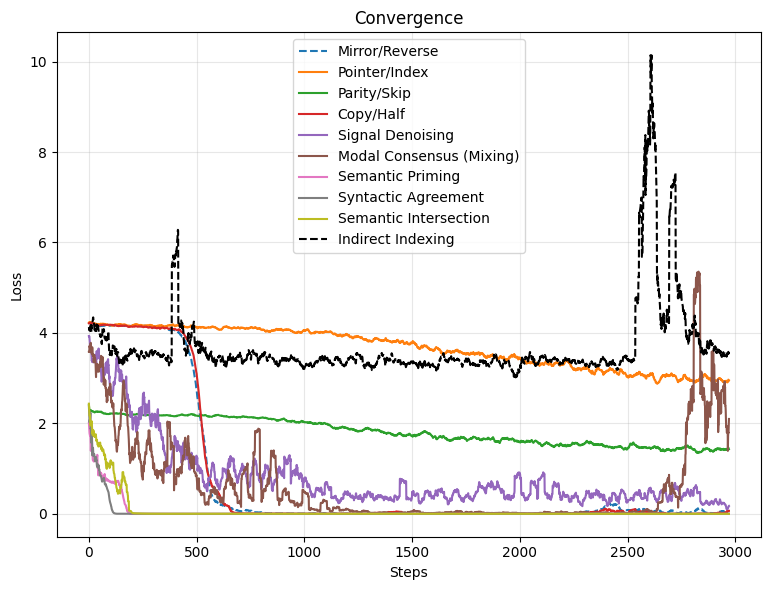

In [13]:
#MIT copyright joshuah.rainstar@gmail.com 2025
#can you improve on these results? i dont mean by tweaking numbers.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --- CONSTANTS ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEQ_LEN = 64
VOCAB_SIZE = 64
EMBED_DIM = 128
STEPS = 3000
LR = 2e-3
IGNORE_INDEX = -100


# --- NEW GENERATORS ---

def generate_reverse_task(batch_size, seq_len, vocab_size, device):
    """
    Task: Output the sequence in reverse order.
    Input: [t1, t2, t3, ...]
    Target: [..., t3, t2, t1]
    Note: Highly difficult for standard causal attention without Bi-RoPE.
    """
    # Generate random sequence
    x = torch.randint(0, vocab_size, (batch_size, seq_len), device=device)

    # Target is the reverse of x
    y = torch.flip(x, dims=[1])

    # Mask out the first half of targets to let the model see some context before predicting
    # (Optional: for pure reverse, we might want to predict immediately,
    # but let's give it a prefix context to make it solvable)
    # Actually, for a pure reverse transformer, it usually needs the full context.
    # Let's do a 'Mirror' task: Input [A, B, C], Target [C, B, A] appended.

    half = seq_len // 2
    prefix = torch.randint(0, vocab_size, (batch_size, half), device=device)

    # Input: [Prefix, Zero_Padding] (Model must fill padding)
    # Actually, standard training is Teacher Forced.
    # Input: [A, B, C, C, B, A]

    x = torch.cat([prefix, torch.flip(prefix, dims=[1])], dim=1)
    y = x.roll(-1, dims=1)

    y[:, -1] = IGNORE_INDEX
    y[:, :half-1] = IGNORE_INDEX # Only penalize the second half (the prediction)

    return x, y

def generate_pointer_task(batch_size, seq_len, vocab_size, device):
    """
    Task: The token at index i contains a value 'p'.
    The target is the content of the token at index 'p'.
    """
    # 1. Content Tokens (Random)
    content = torch.randint(0, vocab_size, (batch_size, seq_len), device=device)

    # 2. Pointer Tokens (Random indices pointing to valid spots)
    # We will alternate: [Content, Pointer, Content, Pointer...]
    # Or simpler: First half is content, Second half is pointers.

    half = seq_len // 2
    bank = torch.randint(0, vocab_size, (batch_size, half), device=device)

    # Pointers point to indices 0..half-1
    pointers = torch.randint(0, half, (batch_size, half), device=device)

    x = torch.cat([bank, pointers], dim=1)

    # Targets
    # For the first half (bank), we don't care (or next token prediction).
    # For the second half (pointers), the target is bank[pointer]

    targets = torch.zeros_like(x)
    targets[:, :half] = IGNORE_INDEX # Ignore bank prediction

    # Gather targets
    # We need to vectorized gather: batch_idx, pointers
    for b in range(batch_size):
        targets[b, half:] = bank[b, pointers[b]]

    # Standard Shift for Causal LM
    # The input at t should predict t+1.
    # So if input at t is a pointer, we want target at t to be the Answer.
    # Wait, standard LM: Predict Next Token.
    # Input: [Bank... | Ptr1, Ans1, Ptr2, Ans2...] is better?
    # Let's stick to the "Copy" structure: Input is given, predict next.
    # If x is [Bank | Pointers], standard LM predicts shifted x.
    # That doesn't work for Pointers.

    # Adjusted Pointer Task:
    # Input: [Content | Query_Index]
    # Target: [ ... | Content[Query_Index]]
    # We do this token by token in the second half.
    # To make it causal:
    # X: [C1, C2, ... | P1, P2, ...]
    # Y: [ ... | Val(P1), Val(P2)...] -> This implies P1 predicts Val(P1).
    # Correct.

    y = targets # The targets we calculated are exactly what we want P_i to predict.
    y[:, -1] = IGNORE_INDEX # Last one has no next token

    return x, y

def generate_parity_task(batch_size, seq_len, vocab_size, device):
    """
    Task: Copy tokens, but only from EVEN positions.
    Input: [A, B, C, D] -> Output [A, A, C, C] (Repeat even tokens)
    Or simpler: The second half should be a copy of the *Even indices* of the first half.
    """
    half = seq_len // 2
    # Ensure half is even for easier reshaping
    if half % 2 != 0: half -= 1

    source = torch.randint(0, vocab_size, (batch_size, half), device=device)

    # Target: Sequence of even indexed items repeated twice to fill length?
    # Let's do: Input [A, B, C, D] -> Target [A, C] (Skip logic)
    # X: [A, B, C, D | A, C, 0, 0]

    evens = source[:, 0::2] # Indices 0, 2, 4...

    # Construct X: Source + Evens + Padding
    # We need to fill SEQ_LEN
    payload_len = evens.shape[1]
    padding = torch.zeros((batch_size, seq_len - half - payload_len), dtype=torch.long, device=device)

    x = torch.cat([source, evens, padding], dim=1)

    # Target (Shifted left)
    y = x.roll(-1, dims=1)
    y[:, :half-1] = IGNORE_INDEX
    y[:, -1] = IGNORE_INDEX

    return x, y

def generate_copy_batch(batch_size, seq_len, vocab_size, device):
    half = seq_len // 2
    # Random first half
    first_half = torch.randint(0, vocab_size, (batch_size, half), device=device)
    # Copy to second half
    x = torch.cat([first_half, first_half], dim=1)

    # Target is x shifted left
    y = x.roll(-1, dims=1)
    y[:, -1] = IGNORE_INDEX

    # Mask out the first half targets to focus loss ONLY on the copy operation
    # We only care about predicting the second half
    y[:, :half-1] = IGNORE_INDEX

    return x, y


def generate_denoise_task(batch_size, seq_len, vocab_size, device):
    """
    Task: Identify the 'Signal' token hidden in noise.
    Input: [N, S, N, N, S, N, S...] where S is the signal.
    Target: Always predict S.
    Reasoning: Lazy Softmax allows the model to sum up the attention
    from all S occurrences, overpowering the scattered noise.
    """
    # Pick a random signal token for each batch
    signals = torch.randint(0, vocab_size, (batch_size, 1), device=device)

    # Generate random noise
    noise = torch.randint(0, vocab_size, (batch_size, seq_len), device=device)

    # Create a mask to inject signals (e.g., 30% signal density)
    # We want enough signal for the 'sum' to work
    mask_prob = 0.35
    mask = torch.rand((batch_size, seq_len), device=device) < mask_prob

    x = torch.where(mask, signals, noise)

    # The target is always the signal, regardless of what the current input is.
    # We want the model to learn "The dominant token in the context is X"
    # Target shape must match x
    y = signals.repeat(1, seq_len)

    # We might want to ignore the first few tokens where context is low
    y[:, :4] = IGNORE_INDEX

    return x, y

def generate_modal_task(batch_size, seq_len, vocab_size, device):
    """
    Task: Identify the most frequent token (The Mode).
    Input: [A, B, A, C, A, D, E, A...] (A is dominant)
    Target: A
    Mechanism: Tests 'Mixing' ability (averaging the context to find the center of mass).
    """
    # 1. Select the "Winner" for each batch
    winner = torch.randint(0, vocab_size - 2, (batch_size, 1), device=device)

    # 2. Generate background noise
    x = torch.randint(0, vocab_size - 2, (batch_size, seq_len), device=device)

    # 3. Inject the winner (e.g., 50% density)
    # Create a mask
    mask = torch.rand((batch_size, seq_len), device=device) < 0.5
    x = torch.where(mask, winner, x)

    # Target is always the winner
    y = winner.repeat(1, seq_len)
    y[:, :10] = IGNORE_INDEX # Ignore early tokens

    return x, y

def generate_priming_task(batch_size, seq_len, vocab_size, device):
    """
    Task: Semantic Priming / Ambiguity Resolution.
    Format: [Context_Marker, ..., Ambiguous_Token] -> Target
    Logic:
      If Context == C1 and Token == T, Target = R1
      If Context == C2 and Token == T, Target = R2
    Mechanism: 'Mixing'.
    The Context_Marker must add a bias vector to the residual stream that
    shifts the ambiguous token's representation into the correct 'meaning' region.
    """
    # Define 2 Contexts and 1 Ambiguous Token
    # C1 -> Target 1
    # C2 -> Target 2

    # Let's say Contexts are tokens 0 and 1.
    # Ambiguous Token is token 2.
    # Targets are 3 and 4.
    C1, C2 = 0, 1
    AMBIG = 2
    TGT1, TGT2 = 3, 4

    # Randomly choose context for each batch
    is_c1 = torch.rand((batch_size,), device=device) > 0.5

    contexts = torch.where(is_c1, torch.tensor(C1, device=device), torch.tensor(C2, device=device))
    targets = torch.where(is_c1, torch.tensor(TGT1, device=device), torch.tensor(TGT2, device=device))

    # Construct Sequence: [Context, Noise..., Ambig]
    x = torch.randint(5, vocab_size, (batch_size, seq_len), device=device) # Noise > 5

    x[:, 0] = contexts
    x[:, -1] = AMBIG

    # Target
    y = torch.full_like(x, IGNORE_INDEX)
    y[:, -1] = targets

    return x, y

def generate_syntactic_agreement_task(batch_size, seq_len, vocab_size, device):
    """
    Task: Subject-Verb Number Agreement.
    Input: [Subject (Sing/Plural), Noise..., Verb_Root]
    Target: Verb_Form (Sing/Plural)
    Mechanism: 'Mixing'.
    The 'Subject' adds a 'Plurality' vector to the residual stream.
    The 'Verb_Root' + 'Plurality' -> 'Verb_Form'.
    """
    # Define Vocabulary Mapping for the Task
    # 0: Singular Subject (e.g., "The Dog")
    # 1: Plural Subject (e.g., "The Dogs")
    # 2: Verb Root (e.g., "run")
    # 3: Singular Verb (e.g., "runs")
    # 4: Plural Verb (e.g., "run")

    SUBJ_SING = 0
    SUBJ_PLUR = 1
    VERB_ROOT = 2
    OUT_SING = 3
    OUT_PLUR = 4

    # Randomly choose number for each batch
    is_plural = torch.rand((batch_size,), device=device) > 0.5

    subjects = torch.where(is_plural, torch.tensor(SUBJ_PLUR, device=device), torch.tensor(SUBJ_SING, device=device))
    targets = torch.where(is_plural, torch.tensor(OUT_PLUR, device=device), torch.tensor(OUT_SING, device=device))

    # Generate Noise (Index 5+)
    x = torch.randint(5, vocab_size, (batch_size, seq_len), device=device)

    # Place Subject early (random pos in first half)
    # We scatter them to prove it's not positional
    locs = torch.randint(0, seq_len // 2, (batch_size, 1), device=device)
    batch_idx = torch.arange(batch_size, device=device).unsqueeze(1)
    x.scatter_(1, locs, subjects.unsqueeze(1))

    # Place Verb Root at the end
    x[:, -1] = VERB_ROOT

    # Target
    y = torch.full_like(x, IGNORE_INDEX)
    y[:, -1] = targets

    return x, y

def generate_semantic_intersection_task(batch_size, seq_len, vocab_size, device):
    """
    Task: Semantic Intersection (Logical AND).
    Input: [Attribute_A, Attribute_B, ..., Query]
    Target: The specific concept matching A + B.
    Example: "Red" + "Fruit" -> "Apple", "Yellow" + "Fruit" -> "Banana"
    Mechanism: 'Palette Composition'.
    The model must sum V(A) + V(B) and decode to V(Target).
    """
    # Define Attributes
    # A1, A2 (e.g., Colors: Red, Yellow)
    # B1, B2 (e.g., Categories: Fruit, Tool)

    # Targets:
    # A1 + B1 -> T1 (Red Fruit -> Apple)
    # A2 + B1 -> T2 (Yellow Fruit -> Banana)
    # A1 + B2 -> T3 (Red Tool -> Wrench?)
    # A2 + B2 -> T4 (Yellow Tool -> Tape Measure?)

    # We map them to indices:
    A1, A2 = 0, 1
    B1, B2 = 2, 3
    T1, T2, T3, T4 = 4, 5, 6, 7
    QUERY = 8

    # Randomly select A and B
    idx_a = torch.randint(0, 2, (batch_size,), device=device) # 0 or 1
    idx_b = torch.randint(0, 2, (batch_size,), device=device) # 0 or 1

    attr_a = torch.where(idx_a == 0, torch.tensor(A1, device=device), torch.tensor(A2, device=device))
    attr_b = torch.where(idx_b == 0, torch.tensor(B1, device=device), torch.tensor(B2, device=device))

    # Determine Target based on combination
    # 0,0 -> T1; 1,0 -> T2; 0,1 -> T3; 1,1 -> T4
    # Simple logic: Target = 4 + (idx_a) + 2*(idx_b)
    # idx_a=0, idx_b=0 -> 4
    # idx_a=1, idx_b=0 -> 5
    # idx_a=0, idx_b=1 -> 6
    # idx_a=1, idx_b=1 -> 7
    targets = 4 + idx_a + 2 * idx_b

    # Construct Sequence
    x = torch.randint(10, vocab_size, (batch_size, seq_len), device=device)

    # Place A and B at random positions
    # We just overwrite two random columns?
    # Let's simple-loop or use scatter.
    # We place A in first half, B in second half to ensure separation
    loc_a = torch.randint(0, seq_len // 2, (batch_size, 1), device=device)
    loc_b = torch.randint(seq_len // 2, seq_len - 1, (batch_size, 1), device=device)

    batch_idx = torch.arange(batch_size, device=device).unsqueeze(1)
    x.scatter_(1, loc_a, attr_a.unsqueeze(1))
    x.scatter_(1, loc_b, attr_b.unsqueeze(1))

    # Trigger at end
    x[:, -1] = QUERY

    y = torch.full_like(x, IGNORE_INDEX)
    y[:, -1] = targets

    return x, y
def generate_indirect_indexing_task(batch_size, seq_len, vocab_size, device):
    """
    Task: Indirect Indexing (Paper Implementation adapted).
    Input: [String, Query_Char, Shift_Amount]
    Target: The character at (Index(Query_Char) + Shift).
    Vocabulary adapted to fit VOCAB_SIZE=64 (Using only A-Z).
    """
    # --- Local Constants mapped to Harness Vocab ---
    # 0: Pad
    # 1-26: Letters A-Z
    # 27-36: Digits 0-9
    # 37: ,  38: Space  39: +  40: -
    PAD = 0
    LETTER_OFF = 1
    DIGIT_OFF = 27
    COMMA, SPACE, PLUS, MINUS = 37, 38, 39, 40

    # Paper parameters
    # CRITICAL FIX: MAX_STR must be <= LETTERS_LEN (26) because we sample without replacement
    LETTERS_LEN = 26
    MIN_STR, MAX_STR = 10, 25
    MAX_SHIFT = 10

    xs_list = []
    ys_list = []

    for _ in range(batch_size):
        # 1. Generate String
        L = torch.randint(MIN_STR, MAX_STR + 1, (1,)).item()

        # Sample unique letters
        perm = torch.randperm(LETTERS_LEN)[:L]
        src_tokens = (perm + LETTER_OFF).tolist()

        # 2. Logic
        shift = torch.randint(-MAX_SHIFT, MAX_SHIFT + 1, (1,)).item()

        # Valid indices i where i+shift is in bounds
        i_min = max(0, -shift)
        i_max = min(L - 1, (L - 1) - shift)

        if i_min > i_max:
            # Fallback if shift makes it impossible to pick a valid start/end
            i = 0
            shift = 0
        else:
            i = torch.randint(i_min, i_max + 1, (1,)).item()

        j = i + shift
        src_char = src_tokens[i]
        tgt_char = src_tokens[j]

        # 3. Serialize Shift
        sign = PLUS if shift >= 0 else MINUS
        s_digits = str(abs(shift))
        digit_tokens = [DIGIT_OFF + int(d) for d in s_digits]

        # 4. Construct Prompt
        # Format: <str> <,> < > <src_char> <,> < > <sign> <digits> <,> < >
        prompt = (
            src_tokens +
            [COMMA, SPACE] +
            [src_char] +
            [COMMA, SPACE] +
            [sign] + digit_tokens +
            [COMMA, SPACE]
        )

        # 5. Create Tensors
        prompt_len = len(prompt)
        pad_len = seq_len - prompt_len

        # Safety check: if prompt is too long, truncate (though params should prevent this)
        if pad_len < 0:
            prompt = prompt[:seq_len]
            pad_len = 0
            prompt_len = seq_len

        x_seq = torch.tensor(prompt + [PAD] * pad_len, dtype=torch.long)

        # Target
        y_seq = torch.full((seq_len,), IGNORE_INDEX, dtype=torch.long)

        # The model must predict 'tgt_char' exactly at the token AFTER the full prompt
        # In a causal LM: Input[t] predicts Label[t].
        # So we want Input[last_prompt_token] to predict tgt_char.
        # This corresponds to index (prompt_len - 1)
        if prompt_len <= seq_len:
            y_seq[prompt_len - 1] = tgt_char

        xs_list.append(x_seq)
        ys_list.append(y_seq)

    x = torch.stack(xs_list).to(device)
    y = torch.stack(ys_list).to(device)

    return x, y

def norm(x):
    return F.rms_norm(x, (x.size(-1),))

class DualCrossAttention(nn.Module):
    def __init__(self, dim, use_sinks=True, lazy_softmax=True):
        super().__init__()
        self.n_heads = 2 # Strictly 2 branches as requested
        self.head_dim = dim // self.n_heads

        self.use_sinks = use_sinks
        self.lazy_softmax = lazy_softmax

        self.q_proj = nn.Linear(dim, dim, bias=False)
        self.k_proj = nn.Linear(dim, dim, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)
        self.o_proj = nn.Linear(dim, dim, bias=False)

        if use_sinks:
            self.v_sink_residual = nn.Parameter(torch.zeros(1, 1, 1, self.head_dim))
            self.v_sink_basis = nn.Parameter(torch.zeros(1, self.n_heads, 1, self.head_dim))

    def get_rotary(self, positions, dim, device):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float().to(device) / dim))
        freqs = torch.einsum("i,d->id", positions, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        return torch.cos(emb)[None, None, :, :], torch.sin(emb)[None, None, :, :]

    def apply_rotary(self, x, cos, sin):
        x_rot = torch.cat([-x[..., 1::2], x[..., 0::2]], dim=-1)
        return (x * cos) + (x_rot * sin)

    def forward(self, x):
        B, T, C = x.shape
        H, D = self.n_heads, self.head_dim

        # Projections [B, T, H, D] -> [B, H, T, D]
        q = self.q_proj(x).view(B, T, H, D).transpose(1, 2)
        k = self.k_proj(x).view(B, T, H, D).transpose(1, 2)
        v = self.v_proj(x).view(B, T, H, D).transpose(1, 2)
        q = F.rms_norm(q, (D,))

        # --- DUAL BRANCH LOGIC ---

        # Positions
        pos_fwd = torch.arange(T, device=x.device).float()
        pos_rev = torch.flip(pos_fwd, dims=[0])

        # Generate RoPE embeddings
        cos_f, sin_f = self.get_rotary(pos_fwd, D, x.device)
        cos_r, sin_r = self.get_rotary(pos_rev, D, x.device)

        # Split Heads
        # q[:, 0] is Head 0, q[:, 1] is Head 1

        # Branch 0: Q,K is Reversed
        q0 = self.apply_rotary(q[:, 0:1], cos_r, sin_r)
        k0 = self.apply_rotary(k[:, 0:1], cos_r, sin_r)

        # Branch 1: Q,K  is Forward
        q1 = self.apply_rotary(q[:, 1:2], cos_f, sin_f)
        k1 = self.apply_rotary(k[:, 1:2], cos_f, sin_f)

        # Recombine for batched matrix multiply
        q_dual = torch.cat([q0, q1], dim=1)
        k_dual = torch.cat([k0, k1], dim=1)

        # Attention
        scores = (q_dual @ k_dual.transpose(-2, -1)) * (D ** -0.5)

        mask = torch.tril(torch.ones(T, T, device=x.device))
        scores = scores.masked_fill(mask == 0, float('-inf'))

        if self.lazy_softmax:
            branch_scores = F.softplus(scores)
            branch_sums = branch_scores.sum(dim=-1, keepdim=True)
            branch_scale = torch.clamp(1.0 / (branch_sums + 1e-6), max=1.0)
            attn = branch_scores * branch_scale
            attn = torch.nan_to_num(attn, nan=0.0)
        else:
            attn = torch.softmax(scores, dim=-1)

        y_context = attn @ v

        if self.use_sinks:
            current_mass = attn.sum(dim=-1, keepdim=True)
            residual = 1.0 - current_mass
            y_res = residual * self.v_sink_residual
            y = y_context + self.v_sink_basis + y_res
        else:
            y = y_context

        y = y.transpose(1, 2).contiguous().view(B, T, -1)
        return self.o_proj(y), attn

class DualCrossAttentionPope(nn.Module):
    def __init__(self, dim, use_sinks=True, lazy_softmax=True):
        super().__init__()
        self.n_heads = 2
        self.head_dim = dim // self.n_heads

        self.use_sinks = use_sinks
        self.lazy_softmax = lazy_softmax

        self.q_proj = nn.Linear(dim, dim, bias=False)
        self.k_proj = nn.Linear(dim, dim, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)
        self.o_proj = nn.Linear(dim, dim, bias=False)

        # PoPE: Learnable Phase Bias [1, Heads, 1, D]
        self.phase_bias = nn.Parameter(torch.zeros(1, self.n_heads, 1, self.head_dim))
        nn.init.zeros_(self.phase_bias)

        if use_sinks:
            self.v_sink_residual = nn.Parameter(torch.zeros(1, 1, 1, self.head_dim))
            self.v_sink_basis = nn.Parameter(torch.zeros(1, self.n_heads, 1, self.head_dim))

    def forward(self, x):
        B, T, C = x.shape
        H, D = self.n_heads, self.head_dim

        # 1. PoPE Constraint: Bound the bias [-2pi, 0]
        self.phase_bias.data.clamp_(min=-2 * np.pi, max=0)

        # 2. PoPE "What": Magnitude Only (Softplus)
        q_raw = self.q_proj(x).view(B, T, H, D).transpose(1, 2)
        k_raw = self.k_proj(x).view(B, T, H, D).transpose(1, 2)
        v = self.v_proj(x).view(B, T, H, D).transpose(1, 2)

        q_mag = F.softplus(q_raw)
        k_mag = F.softplus(k_raw)

        # 3. PoPE "Where": Rotation + Learnable Bias
        inv_freq = 1.0 / (10000 ** (torch.arange(0, D, 1).float().to(x.device) / D))

        pos_fwd = torch.arange(T, device=x.device).float()
        pos_rev = torch.flip(pos_fwd, dims=[0])

        # Base Angles [1, 1, T, D]
        ang_fwd = torch.einsum("i,d->id", pos_fwd, inv_freq).view(1, 1, T, D)
        ang_rev = torch.einsum("i,d->id", pos_rev, inv_freq).view(1, 1, T, D)

        # --- BRANCH 0: REVERSE (Head 0) ---
        # Slice bias for Head 0
        bias_0 = self.phase_bias[:, 0:1]

        q_rot_rev = torch.polar(torch.ones_like(ang_rev), ang_rev)       # Query: Pure Pos
        k_rot_rev = torch.polar(torch.ones_like(ang_rev), ang_rev + bias_0) # Key: Pos + Bias

        q0 = q_mag[:, 0:1] * q_rot_rev
        k0 = k_mag[:, 0:1] * k_rot_rev

        # --- BRANCH 1: FORWARD (Head 1) ---
        # Slice bias for Head 1
        bias_1 = self.phase_bias[:, 1:2]

        q_rot_fwd = torch.polar(torch.ones_like(ang_fwd), ang_fwd)       # Query: Pure Pos
        k_rot_fwd = torch.polar(torch.ones_like(ang_fwd), ang_fwd + bias_1) # Key: Pos + Bias

        q1 = q_mag[:, 1:2] * q_rot_fwd
        k1 = k_mag[:, 1:2] * k_rot_fwd

        # 4. Recombine
        q_dual = torch.cat([q0, q1], dim=1) # [B, 2, T, D]
        k_dual = torch.cat([k0, k1], dim=1) # [B, 2, T, D]

        # 5. Attention (Real part of complex dot product)
        # [B, H, T, D] @ [B, H, D, T] -> [B, H, T, T]
        scores = (q_dual @ k_dual.transpose(-2, -1)).real * (D ** -0.5)

        # Masking and Softmax
        mask = torch.tril(torch.ones(T, T, device=x.device))
        scores = scores.masked_fill(mask == 0, float('-inf'))

        if self.lazy_softmax:
            branch_scores = F.softplus(scores)
            branch_sums = branch_scores.sum(dim=-1, keepdim=True)
            branch_scale = torch.clamp(1.0 / (branch_sums + 1e-6), max=1.0)
            attn = branch_scores * branch_scale
            attn = torch.nan_to_num(attn, nan=0.0)
        else:
            attn = torch.softmax(scores, dim=-1)

        y_context = attn @ v

        if self.use_sinks:
            current_mass = attn.sum(dim=-1, keepdim=True)
            residual = 1.0 - current_mass
            y_res = residual * self.v_sink_residual
            y = y_context + self.v_sink_basis + y_res
        else:
            y = y_context

        y = y.transpose(1, 2).contiguous().view(B, T, -1)
        return self.o_proj(y), attn

# --- WRAPPER ---
class ModelWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
        self.attn = DualCrossAttention(EMBED_DIM)
        #or use DualCrossAttentionPope
        self.mlp = nn.Sequential(
            nn.Linear(EMBED_DIM, EMBED_DIM * 4),
            nn.GELU(),
            nn.Linear(EMBED_DIM * 4, EMBED_DIM)
        )
        self.unembed = nn.Linear(EMBED_DIM, VOCAB_SIZE, bias=False)

    def forward(self, x):
        h = self.embed(x)
        h, attn = self.attn(norm(h))
        h = h + self.mlp(norm(h))
        return self.unembed(h), attn

def run_experiment(task_name, generator_func):
    print(f"Running Task: {task_name}")
    model = ModelWrapper().to(DEVICE)
    opt = optim.AdamW(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

    losses = []
    final_attn = None

    for i in range(STEPS):
        opt.zero_grad()
        x, y = generator_func(1, SEQ_LEN, VOCAB_SIZE, DEVICE)
        logits, attn = model(x)
        loss = loss_fn(logits.view(-1, VOCAB_SIZE), y.view(-1))
        loss.backward()
        opt.step()
        losses.append(loss.item())

        if i == STEPS - 1:
            final_attn = attn.detach()

    return losses, final_attn

print("Starting Experiment...")

l_rev, a_rev = run_experiment("Mirror/Reverse", generate_reverse_task)
l_ptr, a_ptr = run_experiment("Pointer/Index", generate_pointer_task)
l_par, a_par = run_experiment("Parity/Skip", generate_parity_task)
l_half , a_half = run_experiment("Copy/Half", generate_copy_batch)
l_noise, a_noise = run_experiment("Signal Denoising", generate_denoise_task)
l_modal, a_modal = run_experiment("Modal Consensus (Mixing)", generate_modal_task)
l_prime, a_prime = run_experiment("Semantic Priming", generate_priming_task)
l_agree, a_agree = run_experiment("Syntactic Agreement", generate_syntactic_agreement_task)
l_intersect, a_intersect = run_experiment("Semantic Intersection", generate_semantic_intersection_task)
l_ind, a_ind = run_experiment("Indirect Indexing", generate_indirect_indexing_task)


# --- PLOTTING ---
plt.figure(figsize=(15, 6))

# 1. Losses
plt.subplot(1, 2, 1)
def smooth(y): return np.convolve(y, np.ones(30)/30, mode='valid')
plt.plot(smooth(l_rev), label="Mirror/Reverse",linestyle='--')
plt.plot(smooth(l_ptr), label="Pointer/Index")
plt.plot(smooth(l_par), label="Parity/Skip")
plt.plot(smooth(l_half), label="Copy/Half")
plt.plot(smooth(l_noise), label="Signal Denoising")
plt.plot(smooth(l_modal), label="Modal Consensus (Mixing)")
plt.plot(smooth(l_prime), label="Semantic Priming")
plt.plot(smooth(l_agree), label="Syntactic Agreement")
plt.plot(smooth(l_intersect), label="Semantic Intersection")
plt.plot(smooth(l_ind), label="Indirect Indexing", color='black', linestyle='--')

plt.title("Convergence")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()